In [1]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import entropy
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import normalized_mutual_info_score

In [2]:
# calculate entropy
def calentropy(feature, bins = 20):
    c = np.histogram(np.array(df_copy[feature]), bins = 20)[0]
    n_c = c/c.sum()
    return entropy(n_c, base = 2)

In [3]:
# predefined colors in figures
colors = ['#539fac', '#c84947','#f5b23e']

### Import data

In [4]:
# load data
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
ctc = CellTypesCache(manifest_file = 'cell_types/manifest.json')

In [5]:
# download electrophysiology features of all cells
ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)
# download basic cell information from human neurons
cells = ctc.get_cells(species = [CellTypesApi.HUMAN])
cell_df = pd.DataFrame(cells)

cell_df = cell_df[['id','dendrite_type', 'structure_area_abbrev']].rename(columns={'id': 'specimen_id'})
all_df = pd.merge(left = cell_df.set_index('specimen_id'), right = ef_df, 
                  how = 'inner', left_on = 'specimen_id', right_on = 'specimen_id')

### Preprocessing

In [6]:
# exclude integer and binary features
all_df = all_df.drop(columns = ['id', 'thumbnail_sweep_id', 'rheobase_sweep_id', 'rheobase_sweep_number', 
                                'has_burst', 'has_delay', 'has_pause'])
# exclude features where over 30% of values are missing
all_df = all_df.drop(columns= ['slow_trough_t_long_square', 'slow_trough_t_ramp', 'slow_trough_t_short_square', 
                               'slow_trough_v_long_square', 'slow_trough_v_ramp', 'slow_trough_v_short_square'])
# exclude mechanical features that are irrelevant to the intrinsic characteristics of the neurons
all_df = all_df.drop(columns= ['electrode_0_pa', 'seal_gohm'])

# impute missing values
all_df['avg_isi'].fillna(1000, inplace=True) # 1000ms is the maximum value
all_df['adaptation'].fillna(1, inplace=True) 

# exclude cells containing null values in the electrophysiological features
nanlst = []
for cell in range(len(all_df)):
    if True in list(all_df.loc[cell].isnull()):
        nanlst.append(cell)
all_df = all_df.drop(nanlst)

In [7]:
# create LaTeX expression for each feature
abbrevchar = '''$A_{index}$, $ISI_{avg}$, $FR/I$, $t^{long}_{FT}$, $t^{ramp}_{FT}$, $t^{short}_{FT}$, 
                $V^{long}_{FT}$, $V^{ramp}_{FT}$, $V^{short}_{FT}$, $R_{initial}$, $t_{lat}$, $t^{long}_{P}$, 
                $t^{ramp}_{P}$, $t^{short}_{P}$, $V^{long}_{P}$, $V^{ramp}_{P}$, $V^{short}_{P}$, $R_{input}$, 
                $Sag$, $\\tau$, $I^{long}_{\\Theta}$, $I^{ramp}_{\\Theta}$, $I^{short}_{\\Theta}$, $t^{long}_{\\Theta}$, 
                $t^{ramp}_{\\Theta}$, $t^{short}_{\\Theta}$, $V^{long}_{\\Theta}$, $V^{ramp}_{\\Theta}$, 
                $V^{short}_{\\Theta}$, $t^{long}_{T}$, $t^{ramp}_{T}$, $t^{short}_{T}$, $V^{long}_{T}$, 
                $V^{ramp}_{T}$, $V^{short}_{T}$, $\\rho^{long}$, $\\rho^{ramp}$, $\\rho^{short}$, $V^{sag}_{M}$, $V_{rest}$'''
d_feature = {}
abbrevlst = abbrevchar.split(', ')
for n, name in enumerate(list(all_df.columns[3:43])):
    d_feature[name] = abbrevlst[n]

|        Feature name        |        Abbreviation       |
|----------------------------|---------------------------|
|   adaptation               | $A_{index}$ |
|   avg_isi                  | $ISI_{avg}$ |
|   f_i_curve_slope          | $FR/I$      |
| fast_trough_t_long_square  | $t^{long}_{FT}$ |
| fast_trough_t_ramp         | $t^{ramp}_{FT}$ |
| fast_trough_t_short_square | $t^{short}_{FT}$ |
| fast_trough_v_long_square  | $V^{long}_{FT}$ |
| fast_trough_v_ramp         | $V^{ramp}_{FT}$ |
| fast_trough_v_short_square | $V^{short}_{FT}$ |
| input_resistance_mohm      | $R_{initial}$ |
| latency                    | $t_{lat}$ |
| peak_t_long_square         | $t^{long}_{P}$ |
| peak_t_ramp                | $t^{ramp}_{P}$ |
| peak_t_short_square        | $t^{short}_{P}$ |
| peak_v_long_square         | $V^{long}_{P}$ |
| peak_v_ramp                | $V^{ramp}_{P}$ |
| peak_v_short_square        | $V^{short}_{P}$ |
| ri                         | $R_{input}$ | 
| sag                        | $Sag$ |
| tau                        | $\tau$ |
| threshold_i_long_square    | $I^{long}_{\Theta}$ |
| threshold_i_ramp           | $I^{ramp}_{\Theta}$ |
| threshold_i_short_square   | $I^{short}_{\Theta}$ |
| threshold_t_long_square    | $t^{long}_{\Theta}$ |
| threshold_t_ramp           | $t^{ramp}_{\Theta}$ |
| threshold_t_short_square   | $t^{short}_{\Theta}$ |
| threshold_v_long_square    | $V^{long}_{\Theta}$ |
| threshold_v_ramp           | $V^{ramp}_{\Theta}$ |
| threshold_v_short_square   | $V^{short}_{\Theta}$ |
| trough_t_long_square       | $t^{long}_{T}$ |
| trough_t_ramp              | $t^{ramp}_{T}$ |
| trough_t_short_square      | $t^{short}_{T}$ |
| trough_v_long_square       | $V^{long}_{T}$ |
| trough_v_ramp              | $V^{ramp}_{T}$ |
| trough_v_short_square      | $V^{short}_{T}$ |
| upstroke_downstroke_ratio_long_square | $\rho^{long}$ |
| upstroke_downstroke_ratio_ramp | $\rho^{ramp}$ |
| upstroke_downstroke_ratio_short_square | $\rho^{short}$ |
| vm_for_sag                 | $V^{sag}_{M}$ |
| vrest                      | $V_{rest}$ |

In [8]:
d_type = {}
for n in all_df['dendrite_type']:
    if n not in d_type:
        d_type[n] = 0
    d_type[n] += 1
    
print('Types of dentrites: ')
print(d_type)

Types of dentrites: 
{'spiny': 321, 'aspiny': 78, 'sparsely spiny': 13}


### Plot overview figures

In [9]:
# sort features for violin plot
v1lst = []; v2lst = []; rlst = []; t1lst = []; t2lst = []; t3lst = []; ilst = []; slst = []
for f in list(all_df.columns[3:43]):
    if 'v' in f.split('_'):
        if 'peak' in f.split('_'):
            v2lst.append(f)
        else:
            v1lst.append(f)
    elif 'upstroke' in f.split('_'):
        rlst.append(f)
    elif 't' in f.split('_'):
        if 'ramp' in f.split('_'):
            t2lst.append(f)
        elif 'short' in f.split('_'):
            t3lst.append(f)
        else:
            t1lst.append(f)
    elif 'i' in f.split('_'):
        ilst.append(f)
    else:
        slst.append(f)
slst.append('f_i_curve_slope')
ilst.remove('f_i_curve_slope')
t3lst.remove('trough_t_short_square')
t1lst.append('trough_t_short_square')

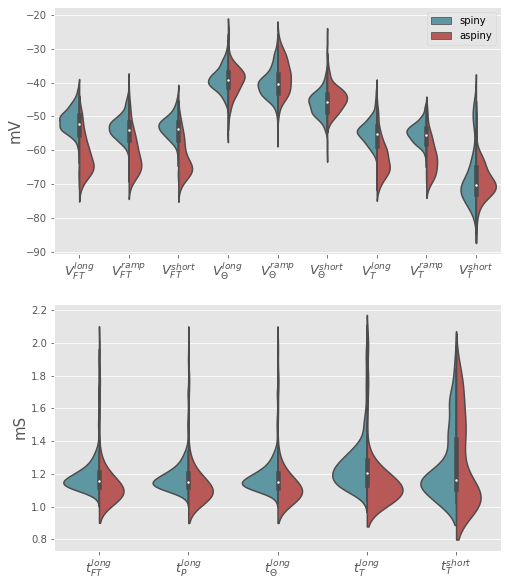

In [10]:
plt.style.use('ggplot')
f, axes = plt.subplots(2, 1, figsize=(8, 10))
sns.set_palette(colors[:2])

v1d = pd.melt(all_df[(all_df['dendrite_type'] != 'sparsely spiny')], value_vars=v1lst, id_vars='dendrite_type')
sns.violinplot(x = 'variable', y='value', hue = 'dendrite_type', data=v1d, split=True, ax = axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('mV', fontsize = 15)
v1lab = []
for f in v1lst:
    v1lab.append(d_feature[f])
axes[0].set_xticklabels(v1lab, fontsize = 13)
axes[0].legend(title='')

t1ld = pd.melt(all_df[(all_df['dendrite_type'] != 'sparsely spiny')], value_vars=t1lst, id_vars='dendrite_type')
sns.violinplot(x = 'variable', y='value', hue = 'dendrite_type', data=t1ld, split=True, ax = axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('mS', fontsize = 15)
t1lab = []
for f in t1lst:
    t1lab.append(d_feature[f])
axes[1].set_xticklabels(t1lab, fontsize = 13)
axes[1].get_legend().set_visible(False)
plt.show()

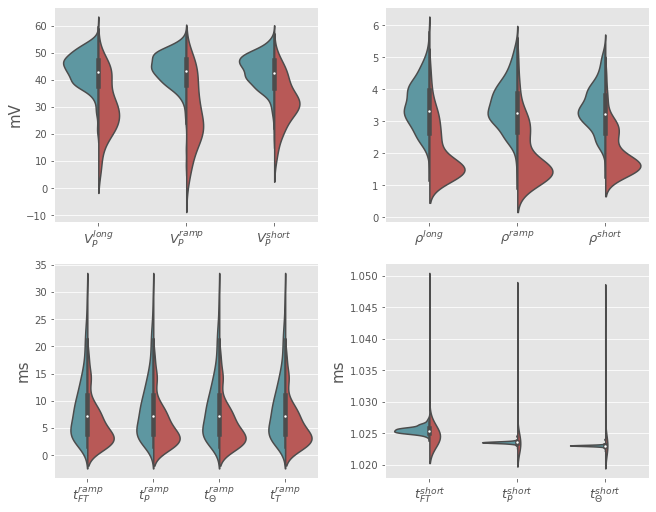

In [11]:
f, axes = plt.subplots(2, 2, figsize=(9, 7), constrained_layout=True)
sns.set_palette(colors[:2])

v2d = pd.melt(all_df[(all_df['dendrite_type'] != 'sparsely spiny')], value_vars=v2lst, id_vars='dendrite_type')
sns.violinplot(x = 'variable', y='value', hue = 'dendrite_type', data=v2d, split=True, ax = axes[0,0])
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('mV', fontsize = 15)
v2lab = []
for f in v2lst:
    v2lab.append(d_feature[f])
axes[0,0].set_xticklabels(v2lab, fontsize = 13)
axes[0,0].get_legend().set_visible(False)

t2ld = pd.melt(all_df[(all_df['dendrite_type'] != 'sparsely spiny')], value_vars=t2lst, id_vars='dendrite_type')
sns.violinplot(x = 'variable', y='value', hue = 'dendrite_type', data=t2ld, split=True, ax = axes[1,0])
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('ms', fontsize = 15)
t2lab = []
for f in t2lst:
    t2lab.append(d_feature[f])
axes[1,0].set_xticklabels(t2lab, fontsize = 13)
axes[1,0].get_legend().set_visible(False)

rd = pd.melt(all_df[(all_df['dendrite_type'] != 'sparsely spiny')], value_vars=rlst, id_vars='dendrite_type')
sns.violinplot(x = 'variable', y='value', hue = 'dendrite_type', data=rd, split=True, ax = axes[0,1])
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('')
rlab = []
for f in rlst:
    rlab.append(d_feature[f])
axes[0,1].set_xticklabels(rlab, fontsize = 13)
axes[0,1].get_legend().set_visible(False)

t3ld = pd.melt(all_df[(all_df['dendrite_type'] != 'sparsely spiny')], value_vars=t3lst, id_vars='dendrite_type')
sns.violinplot(x = 'variable', y='value', hue = 'dendrite_type', data=t3ld, split=True, ax = axes[1,1])
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('ms', fontsize = 15)
t3lab = []
for f in t3lst:
    t3lab.append(d_feature[f])
axes[1,1].set_xticklabels(t3lab, fontsize = 13)
axes[1,1].get_legend().set_visible(False)

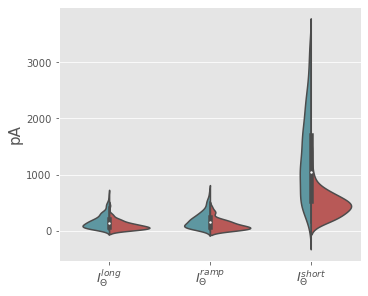

In [12]:
f, axes = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
#plt.tight_layout()
sns.set_palette(colors[:2])

ild = pd.melt(all_df[(all_df['dendrite_type'] != 'sparsely spiny')], value_vars=ilst, id_vars='dendrite_type')
sns.violinplot(x = 'variable', y='value', hue = 'dendrite_type', data=ild, split=True)
axes.set_xlabel('')
axes.set_ylabel('pA', fontsize = 15)
ilab = []
for f in ilst:
    ilab.append(d_feature[f])
axes.set_xticklabels(ilab, fontsize = 13)
axes.get_legend().set_visible(False)

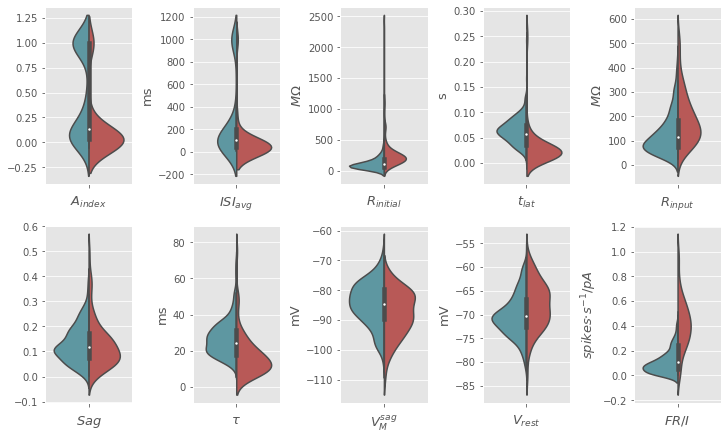

In [13]:
ylab = ['','ms', '$M\\Omega$', 's', '$M\\Omega$', '', 'ms', 'mV', 'mV', '$spikes{\\cdot}s^{-1}/pA$']
f, axes = plt.subplots(2, 5, figsize=(10, 6), constrained_layout=True)
sns.set_palette(colors[:2])
n = 0
for i in range(2):
    for j in range(5):
        sd = pd.melt(all_df[(all_df['dendrite_type'] != 'sparsely spiny')], value_vars=slst[n], id_vars='dendrite_type')
        sns.violinplot(x = 'variable', y='value', hue = 'dendrite_type', data=sd, split=True, ax = axes[i,j])
        axes[i,j].set_xlabel(d_feature[slst[n]], fontsize = 13)
        axes[i,j].set_ylabel(ylab[n], fontsize = 13)
        axes[i,j].set_xticklabels('')
        axes[i,j].get_legend().set_visible(False)
        n += 1

### Calculate and plot coefficient of correlation

In [14]:
df_copy = all_df.drop(columns = ['specimen_id', 'dendrite_type', 'structure_area_abbrev'])

corr_matrix = df_copy.corr()

# rearrange features in covariance heatmap
covhcluster = AgglomerativeClustering(n_clusters=None, distance_threshold=1).fit(corr_matrix)
counts = np.zeros(covhcluster.children_.shape[0])
linkage_matrix = np.column_stack([covhcluster.children_, covhcluster.distances_, counts]).astype(float)
df_lab = df_copy.T
df_lab['hclabel'] = covhcluster.labels_
df_lab = df_lab.sort_values(by=['hclabel']).drop(columns=['hclabel']).T
hc_cov_matrix = df_lab.corr()

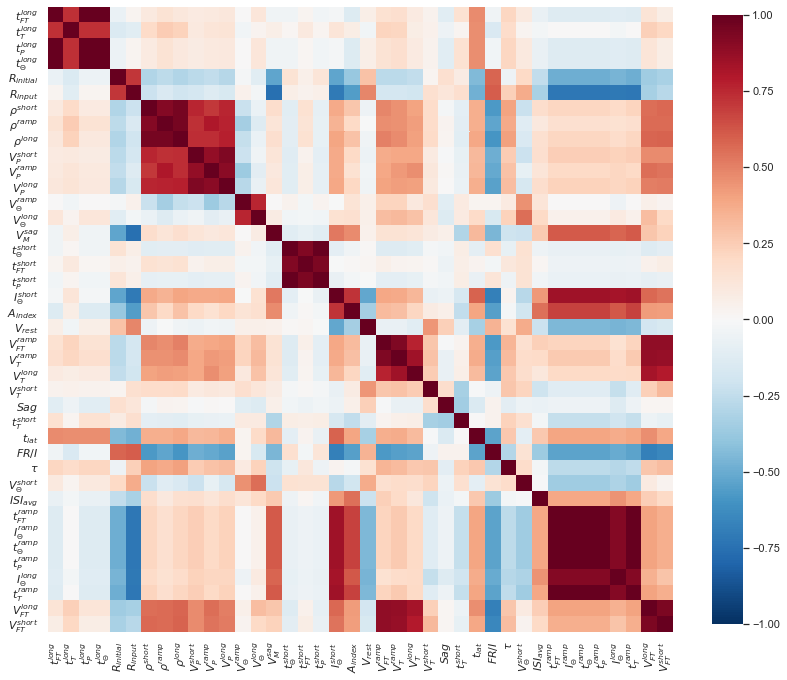

In [15]:
# create LaTeX labels for heatmap
lablst = []
for name in list(hc_cov_matrix.columns):
    lablst.append(d_feature[name])

sns.set(rc={'figure.figsize':(14,14)})
sns.heatmap(hc_cov_matrix, cmap = 'RdBu_r', square = True, cbar_kws={'shrink':0.8}, 
            xticklabels = lablst, yticklabels = lablst, vmin=-1)

### Calculate entropy of each feature

In [16]:
d_entropy = {}
for feature in df_copy.columns:
    d_entropy[feature] = calentropy(feature)

df_entropy = pd.DataFrame.from_dict(d_entropy, orient='index', columns=['Entropy'])
df_entropy

,Entropy
adaptation,2.642821
avg_isi,2.719466
f_i_curve_slope,3.239017
fast_trough_t_long_square,2.806131
fast_trough_t_ramp,3.652533
fast_trough_t_short_square,1.414177
fast_trough_v_long_square,3.835839
fast_trough_v_ramp,3.689696
fast_trough_v_short_square,3.786467
input_resistance_mohm,1.527011


### Calculate and plot normalized mutual information

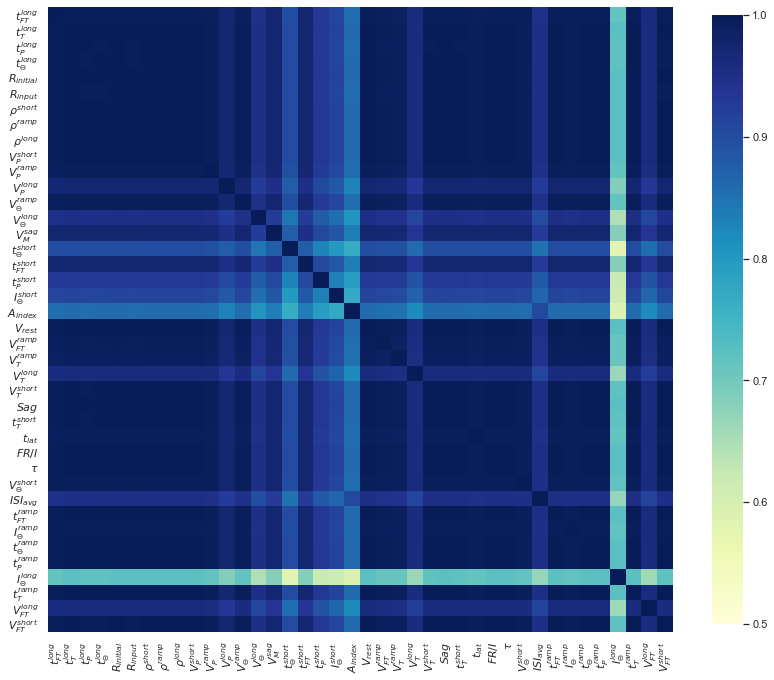

In [17]:
comb = product(np.arange(len(hc_cov_matrix)), repeat=2)
mi = np.ones_like(hc_cov_matrix)
for n in list(comb):
    mi[n[0], n[1]] = normalized_mutual_info_score(df_lab[df_lab.columns[n[0]]], df_lab[df_lab.columns[n[1]]])
    
df_mi = pd.DataFrame(mi.T, index = hc_cov_matrix.columns, columns = hc_cov_matrix.columns)
sns.set(rc={'figure.figsize':(14,14)})

sns.heatmap(df_mi, cmap = 'YlGnBu', square = True, cbar_kws={'shrink':0.8}, 
            xticklabels = lablst, yticklabels = lablst, vmin=0.5)